# Joint Fermi-LAT and H.E.S.S. analysis : Source detection

In [1]:
import time
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack, unique
import astropy.units as u
import matplotlib.pyplot as plt 
import numpy as np 

from gammapy.maps import Map, MapCoord
from gammapy.datasets import Datasets
from gammapy.modeling.models import Models, PointSpatialModel, PowerLawSpectralModel, SkyModel, LogParabolaSpectralModel, GeneralizedGaussianSpatialModel
from gammapy.modeling import Fit
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators.utils import get_combined_significance_maps
from gammapy.catalog import CATALOG_REGISTRY

## Datasets setup

First we load the datasets previously created

In [2]:
datasets_fermi = Datasets.read(
    filename="./datasets/fermi_lat_rxj_datasets.yaml", filename_models="./models/fermi_lat_rxj_models.yaml"
)

datasets_hess = Datasets.read(
    filename="./datasets/hess_rxj_datasets.yaml", filename_models="./models/hess_rxj_models.yaml"
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


We create a joint datasets list

In [3]:
datasets = Datasets(list(datasets_fermi) + list(datasets_hess))
#TODO: we lack the addition on Datasets, who want to open a PR ?

We want to refit the sources that are seens by both instruments
We select are going to select only the fermi-lat models that are not seen by H.E.S.S.

In [4]:
models_hgps_geom = Models.read("./models/hgps_rxj_models.yaml")

In [5]:
fermi_sources = Models(datasets_fermi.models.select(name_substring="4FGL"))
selection = np.array([np.all(m.position.separation(models_hgps_geom.positions) > 0.1*u.deg) for m in fermi_sources])
fermi_sources_selection = fermi_sources[selection]

and the backgrounds

In [6]:
model_iem = Models(datasets_fermi.models[ "IEM_varmin_rescaled"])
models_fermi_iso = Models(datasets_fermi.models.select(tag="const", model_type="spatial"))
models_hess_bkg = Models(datasets_hess.models.select(tag="fov-bkg"))

You can check the `datasets_names` attribute on a given model to check on which dataset it is applied.
By default it is `None` and apply to everything.

In [7]:
models_hess_bkg[0].datasets_names

['hess_rxj_stacked']

Now we can assign the models to the datasets (and this will take into account `datasets_names` assignment)

In [8]:
models = fermi_sources_selection + model_iem + models_fermi_iso + models_hess_bkg
datasets.models = models

## Joint TS map

This use forward folding to convolve a given nev model by the IRFs and move it in every pixel to evalaute the significance of the excess above the existing models.

In [9]:
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

ts_estimator = TSMapEstimator(
    model,
    kernel_width="1 deg",  # this set close to the 95-99% containment radius of the PSF
    selection_optional=[],
    sum_over_energy_groups=True,
    energy_edges=[10, 1000] * u.GeV,
    n_jobs=4, #this will run in parallel
)


In [10]:
%%time
ts_results_fermi = ts_estimator.run(datasets_fermi)

CPU times: user 22.8 s, sys: 3.09 s, total: 25.9 s
Wall time: 40 s


In [11]:
%%time
ts_results_hess = ts_estimator.run(datasets_hess)

HDU 'MASK_FIT' not found
Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 13.3 s, sys: 914 ms, total: 14.2 s
Wall time: 21.1 s


In [12]:
%%time
ts_results_joint = ts_estimator.run(datasets)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 35.6 s, sys: 3.55 s, total: 39.1 s
Wall time: 59.1 s


Let's plot everything together

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

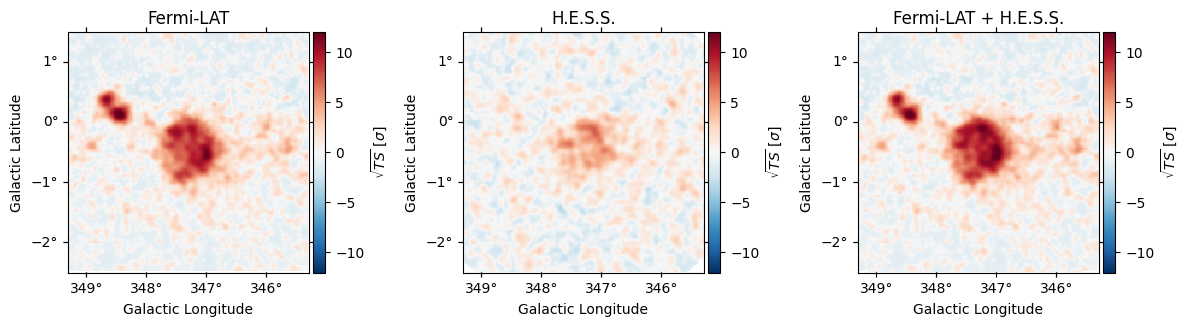

In [13]:
def plot_cutout(image, ax, plot_kwargs=None, margin=2*u.deg):
    image = image.cutout(
        image.geom.center_skydir, width=np.max(image.geom.width) - 2 * margin
    )
    kwargs = dict(ax=ax)
    if plot_kwargs : 
        kwargs.update(plot_kwargs)
    image.plot(**kwargs)

margin=2*u.deg
geom = datasets[0].counts.geom
fig_geom = geom.cutout(geom.center_skydir, width=np.max(geom.width) - 2 * margin)
resi_kwargs =dict(
        clim=[-12, 12],
        cmap=plt.cm.RdBu_r,
        add_cbar=True,
        kwargs_colorbar={"label": r"$\sqrt{TS}$ [$\sigma$]"},
    )

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(131, projection=fig_geom.wcs)
plot_cutout(ts_results_fermi["sqrt_ts"], ax1, resi_kwargs)
ax1.set_title("Fermi-LAT")

ax2 = plt.subplot(132, projection=fig_geom.wcs)
plot_cutout(ts_results_hess["sqrt_ts"], ax2, resi_kwargs)
ax2.set_title("H.E.S.S.")

ax3 = plt.subplot(133, projection=fig_geom.wcs)
plot_cutout(ts_results_joint["sqrt_ts"], ax3, resi_kwargs)
ax3.set_title("Fermi-LAT + H.E.S.S.")

plt.tight_layout()

## Excess Maps

This use backward folding to estimate the TS and the flux in a given correlation radius.
In that case the predicted counts are the excess counts. The flux is the excess counts divided by the reconstructed exposure. So only the flux depends on the spectral model assumption not the TS.

In [14]:
estimator_rcorr0p1 = ExcessMapEstimator(correlation_radius="0.1 deg", spectral_model=spectral_model)

This will give use one estimation per dataset that we can combine together using `get_combined_significance_maps`.

The significance computation assumes that the model contains one degree of freedom per valid energy bin in each dataset.
This method implemented here is valid under the assumption that the TS in each independent bin follows a Chi2 distribution,
then the sum of the TS also follows a Chi2 distribution (with the sum of degree of freedom).

In [15]:
#get_combined_significance_maps?

In [16]:
%%time
results_combined_rcorr0p1 = get_combined_significance_maps(estimator_rcorr0p1, datasets)


Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 23.1 s, sys: 1.8 s, total: 24.9 s
Wall time: 24.3 s


This approach is much faster than the TS map compuation but less precise in particular close to TS=0 where the validity of the hypostheses might break. However above few sigma this will point us toward the same excesses.

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

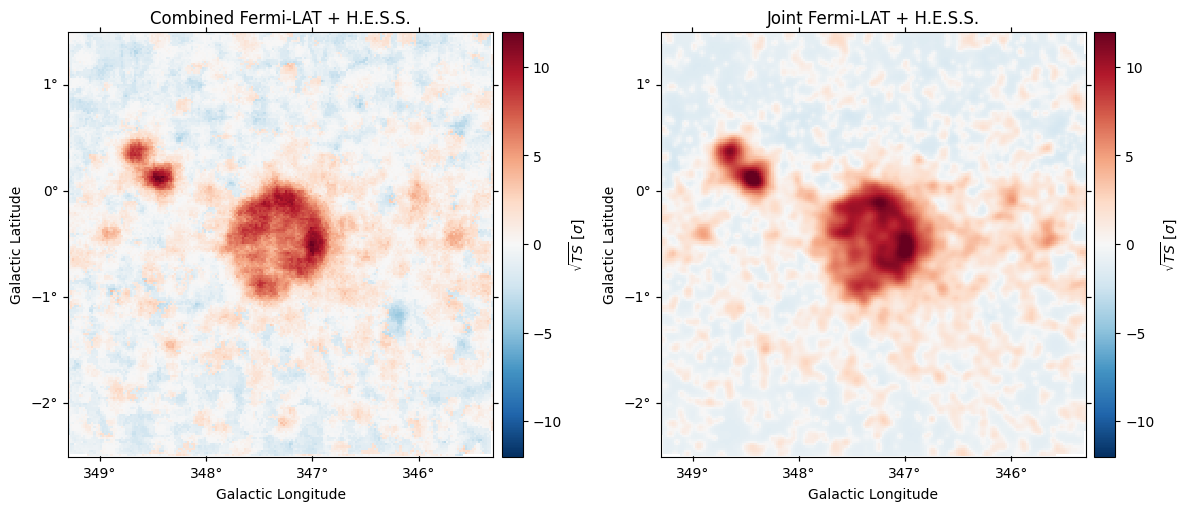

In [17]:
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(121, projection=fig_geom.wcs)
plot_cutout(results_combined_rcorr0p1["significance"], ax1, resi_kwargs)
ax1.set_title("Combined Fermi-LAT + H.E.S.S.")

ax2 = plt.subplot(122, projection=fig_geom.wcs)
plot_cutout(ts_results_joint["sqrt_ts"], ax2, resi_kwargs)
ax2.set_title("Joint Fermi-LAT + H.E.S.S.")


plt.tight_layout()

As it is much faster we can test more model hypothesis in term of sizes

In [18]:
estimator_rcorr0p2 = ExcessMapEstimator(correlation_radius="0.2 deg", spectral_model=spectral_model)
results_combined_rcorr0p2 = get_combined_significance_maps(estimator_rcorr0p2, datasets)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

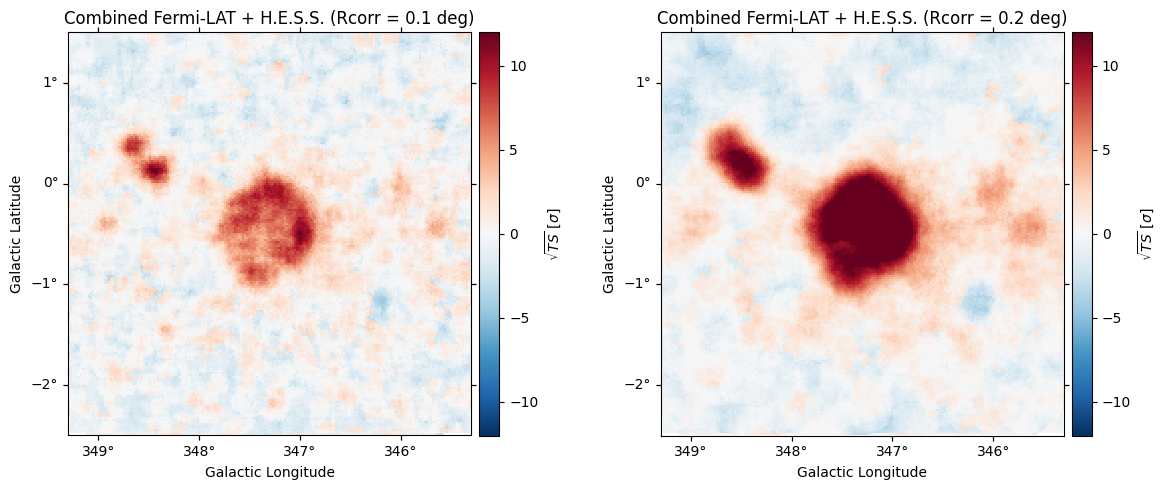

In [19]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121, projection=fig_geom.wcs)
plot_cutout(results_combined_rcorr0p1["significance"], ax1, resi_kwargs)
ax1.set_title("Combined Fermi-LAT + H.E.S.S. (Rcorr = 0.1 deg)")

ax2 = plt.subplot(122, projection=fig_geom.wcs)
plot_cutout(results_combined_rcorr0p2["significance"], ax2, resi_kwargs)
ax2.set_title("Combined Fermi-LAT + H.E.S.S. (Rcorr = 0.2 deg)")


plt.tight_layout()

## Image filtering

Now we are going to use some technique from scikit-image to filter out the residual noise and keep only the significant excess.
Here we use a method called Hysteresis filtering. Two thresholds are used: first, pixels above the higher threshold are selected, and then pixels between the two thresholds are selected only if they are continuously connected to a pixel above the high threshold. 

See Also: https://scikit-image.org/docs/0.25.x/auto_examples/filters/plot_hysteresis.html

In [20]:
from skimage import filters

In [21]:
sig_low = 2
sig_hig = 4

sig_rcorr0p1 = results_combined_rcorr0p1["significance"]

hysteresis_mask  = filters.apply_hysteresis_threshold(sig_rcorr0p1,sig_low,sig_hig)
sig_rcorr0p1_fil = sig_rcorr0p1*hysteresis_mask

We can also used `scipy.ndimage` to label the structures isolated and remove those smaller than a given number of pixels

In [22]:
import scipy.ndimage as ndi
def filter_isolated_cells(map_, struct=None, Nmin=1):
    """ Return array with completely isolated single cells removed
    :param array: Array with completely isolated single cells
    :param struct: Structure array for generating unique regions
    :return: Array with minimum region size > Nmin
    """
    geom = map_.geom
    array = map_.data
    if struct is None:
        struct = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    filtered_array = np.copy(array)
    id_regions, num_ids = ndi.label(filtered_array, structure=struct)
    id_sizes = np.array(ndi.sum(array, id_regions, range(num_ids + 1)))
    area_mask = id_sizes <= Nmin
    filtered_array[area_mask[id_regions]] = 0
    id_regions, num_ids = ndi.label(filtered_array, structure=struct)

    filtered_map = Map.from_geom(geom, data=filtered_array)
    id_regions = Map.from_geom(geom, data=id_regions)
    num_ids = Map.from_geom(geom, data=num_ids)

    return filtered_map, id_regions, num_ids

In [23]:
sig_rcorr0p1_fil_clean, id_regions, num_ids = filter_isolated_cells(sig_rcorr0p1_fil, struct=np.ones((3,3)), Nmin=10)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

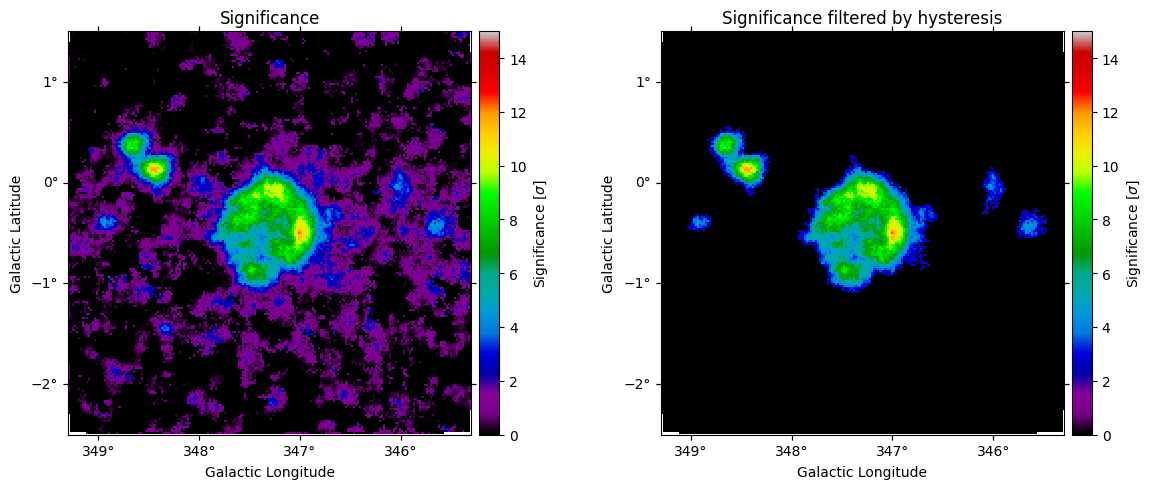

In [24]:
resi_fil_kwargs = dict(
    clim=[0, 15],
    cmap=plt.cm.nipy_spectral,
    add_cbar=True,
    kwargs_colorbar={"label": r"Significance [$\sigma$]"})

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121, projection=fig_geom.wcs)
plot_cutout(sig_rcorr0p1, ax1, resi_fil_kwargs)
ax1.set_title("Significance")


ax2 = plt.subplot(122, projection=fig_geom.wcs)
plot_cutout(sig_rcorr0p1_fil, ax2, resi_fil_kwargs)
ax2.set_title("Significance filtered by hysteresis")
, 
plt.tight_layout()

We can select and visualize the different structure using the `id_regions` created

<WCSAxes: >

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


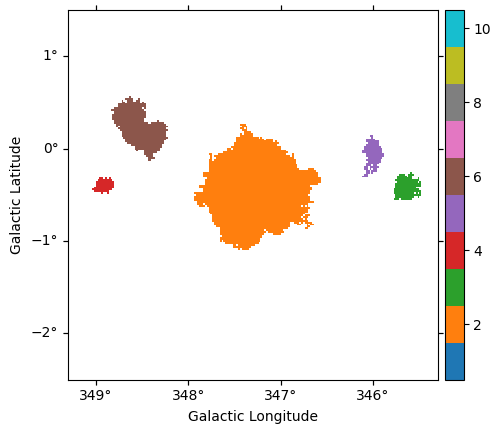

In [25]:
id_regions_cut = id_regions.cutout(
        id_regions.geom.center_skydir, width=np.max(id_regions.geom.width) - 2 * margin
    )
id_regions_cut.data = id_regions_cut.data.astype(float)
id_regions_cut.data[id_regions_cut<=1]=np.nan

id_regions_cut.plot(cmap=plt.cm.tab10, add_cbar=True, vmin=0.5, vmax=10.5)

## Source detection

Now let's apply some technique to localize the significance peak and derive a guess for the source size and try to split these structures in smaller pieces.

### Peak detection

Find local maxima separated from a given minimal distance

In [26]:
from gammapy.estimators.utils import find_peaks

In [27]:
peaks = find_peaks(sig_rcorr0p1_fil, threshold=4, min_distance="0.1 deg")
peaks

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
12.367,214,199,258.18017,-40.04539
11.986,141,230,258.63668,-38.49909
10.641,205,218,257.91846,-39.67601
10.446,198,222,257.94194,-39.51578
10.205,192,218,258.11735,-39.46602
9.2872,131,241,258.55804,-38.20825
8.9957,190,180,258.94854,-39.87821
7.2608,188,193,258.70380,-39.69427


In [28]:
peak_coords = SkyCoord(peaks["ra"], peaks["dec"], frame="icrs").galactic

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


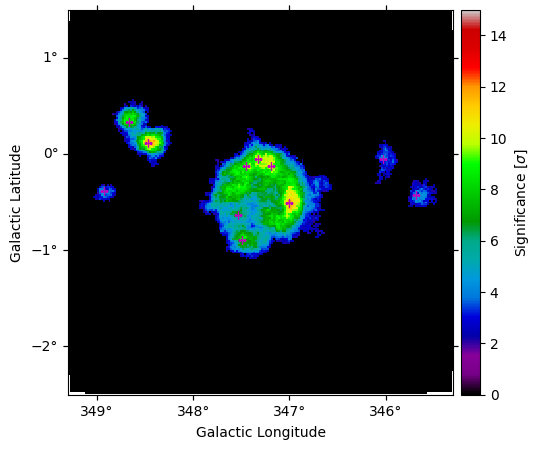

In [29]:
plt.figure(figsize=(7, 5))
ax = plt.subplot(111, projection=fig_geom.wcs)
plot_cutout(sig_rcorr0p1_fil, ax, resi_fil_kwargs)
ax.plot_coord(peak_coords, " m+")

###  Watershed Segmentation

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on watershed lines

We generate markers at the local maxima of the significance and we run the watershed on the negative significance image.

See Also: https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_watershed.html

In [30]:
from skimage.segmentation import watershed

In [31]:
peak_map = Map.from_geom(sig_rcorr0p1_fil.geom, data=False)
for ix, iy in zip(peaks["x"], peaks["y"]):
    peak_map.data[iy, ix] = True #TODO: is the order correct or a bug ?
markers, _ = ndi.label(peak_map.data)

In [32]:
image = sig_rcorr0p1_fil.data
image[~np.isfinite(image)] = 0.
watershed_labels = watershed(-image, markers = markers, mask=image)
id_regions_watershed =  Map.from_geom(sig_rcorr0p1_fil.geom, data=watershed_labels.astype(float))

<WCSAxes: >

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


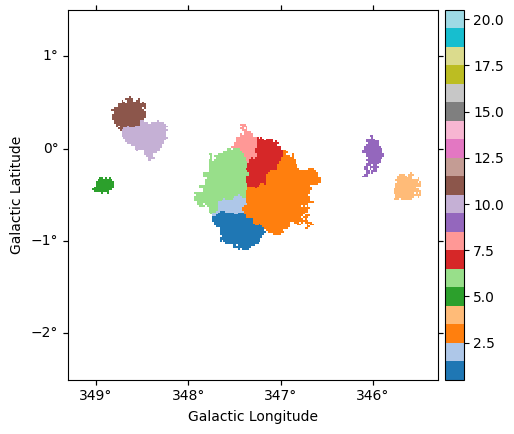

In [33]:
id_regions_watershed_cut = id_regions_watershed.cutout(
        id_regions_watershed.geom.center_skydir, width=np.max(id_regions_watershed.geom.width) - 2 * margin
    )
id_regions_watershed_cut.data[id_regions_watershed_cut==0]=np.nan

id_regions_watershed_cut.plot(cmap=plt.cm.tab20, add_cbar=True, vmin=0.5, vmax=20.5)

### Regions properties

We can measure the size of the regions isolated with `skimage.measure.regionprops`.

See Also: https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_regionprops.html#measure-region-properties

In [34]:
from skimage.measure import regionprops, regionprops_table

In [35]:
props_generator = regionprops(id_regions_cut.data.astype(int))


props_table = regionprops_table(id_regions_cut.data.astype(int),
                                properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)


props_generator_watershed = regionprops(id_regions_watershed_cut.data.astype(int))

props_table_watershed = regionprops_table( id_regions_watershed_cut.data.astype(int),
                                properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)



/var/folders/c6/mnwlhxw94_b2r4wqsh2d16d80000gp/T/ipykernel_16900/689354212.py:1: RuntimeWarning: invalid value encountered in cast
  props_generator = regionprops(id_regions_cut.data.astype(int))
/var/folders/c6/mnwlhxw94_b2r4wqsh2d16d80000gp/T/ipykernel_16900/689354212.py:4: RuntimeWarning: invalid value encountered in cast
  props_table = regionprops_table(id_regions_cut.data.astype(int),
/var/folders/c6/mnwlhxw94_b2r4wqsh2d16d80000gp/T/ipykernel_16900/689354212.py:9: RuntimeWarning: invalid value encountered in cast
  props_generator_watershed = regionprops(id_regions_watershed_cut.data.astype(int))
/var/folders/c6/mnwlhxw94_b2r4wqsh2d16d80000gp/T/ipykernel_16900/689354212.py:11: RuntimeWarning: invalid value encountered in cast
  props_table_watershed = regionprops_table( id_regions_watershed_cut.data.astype(int),


In [36]:
def plot_region_props(props_generator, ax):
    for props in props_generator:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
        y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
        x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
        y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length
    
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
        ax.plot(x0, y0, '.g', markersize=8)
    
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=1.5)


Text(0.5, 1.0, 'Watershed segmented regions')

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

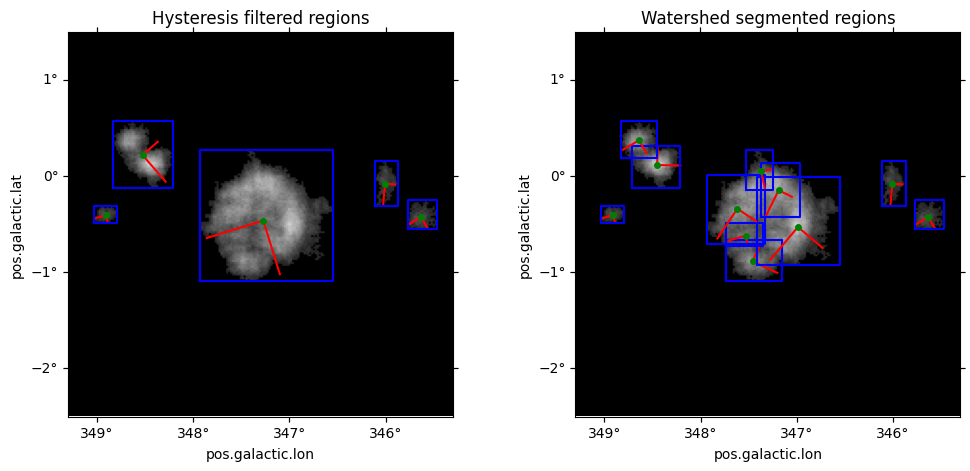

In [37]:
sig_rcorr0p1_fil_cut = sig_rcorr0p1_fil.cutout(
        sig_rcorr0p1_fil.geom.center_skydir, width=np.max(sig_rcorr0p1_fil.geom.width) - 2 * margin
    )
geom_cut = sig_rcorr0p1_fil_cut.geom

plt.show()
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121, projection=geom_cut.wcs)
ax1.imshow(sig_rcorr0p1_fil_cut, cmap=plt.cm.gray, vmax=15)
plot_region_props(props_generator, ax1)
ax1.set_title("Hysteresis filtered regions")

ax2 = plt.subplot(122, projection=geom_cut.wcs)
ax2.imshow(sig_rcorr0p1_fil_cut, cmap=plt.cm.gray, vmax=15)
plot_region_props(props_generator_watershed, ax2)
ax2.set_title("Watershed segmented regions")

We can merge both table and add information in degree

In [38]:
from astropy.table import Table, vstack, unique
candidates_table = unique(vstack([Table(props_table), Table(props_table_watershed)]))


In [39]:
pix_scale = geom_cut.pixel_scales[0]
candidates_table["glon"], candidates_table["glat"] = geom_cut.pix_to_coord((candidates_table["centroid-1"], candidates_table["centroid-0"]))
candidates_table["r_minor"] = candidates_table["axis_minor_length"]*pix_scale/2.
candidates_table["r_major"] = candidates_table["axis_major_length"]*pix_scale/2
candidates_table["r_mean"] = (candidates_table["r_minor"]+candidates_table["r_major"])/2.

we can add associations to H.E.S.S. sources

In [40]:
candidates_coords = SkyCoord(candidates_table["glon"], candidates_table["glat"], frame="galactic")

n_rows = len(candidates_table)
candidates_table["asso"]=np.zeros(n_rows, dtype="U20")
candidates_table["asso_sep"]=np.zeros(n_rows, dtype=float)*u.deg*np.nan

for m in models_hgps_geom:
    sep = m.position.separation(candidates_coords)
    idx = np.argmin(sep)
    if sep[idx]<0.1*u.deg:
        candidates_table["asso"][idx] = m.name
        candidates_table["asso_sep"].quantity[idx] = sep[idx]


and a flag to identify isolated objects

In [41]:
candidates_table["isolated"]=np.zeros(n_rows, dtype=bool)
for idx in range(n_rows):
    others = np.arange(n_rows)!=idx
    candidates_table["isolated"][idx] = np.all(candidates_coords[idx].separation(
        candidates_coords[others])> candidates_table["r_mean"][idx]+ candidates_table["r_mean"][others])

Let's reorder the table and display

In [42]:
candidates_table = candidates_table[["glon", "glat", "r_mean", "r_minor", "r_major", "asso", "asso_sep", "isolated", "centroid-1", "centroid-0", "axis_minor_length",  "axis_major_length"]]
candidates_table

glon,glat,r_mean,r_minor,r_major,asso,asso_sep,isolated,centroid-1,centroid-0,axis_minor_length,axis_major_length
deg,deg,deg,deg,deg,,deg,,,,,
float64,float64,float64,float64,float64,str20,float64,bool,float64,float64,float64,float64
347.4595807231454,-0.8879520250613256,0.23254015096556102,0.18107854487415026,0.2840017570569718,,nan,False,91.52173913043478,80.10230179028133,18.107854487415025,28.40017570569718
347.53190974240397,-0.623444180409288,0.1381742818130054,0.0926013423013429,0.18374722132466786,,nan,False,87.90517241379311,93.32758620689656,9.26013423013429,18.374722132466786
346.988025114986,-0.531624119159979,0.3905573390897222,0.33640887558953003,0.4447058025899143,,nan,False,115.0980751604033,97.91842346471127,33.640887558953004,44.47058025899143
347.27178571397855,-0.46482459792597836,0.5986289801397595,0.5823374313902333,0.6149205288892857,HESS J1713-397,0.03977395480702753,False,100.91066814322629,101.25876707272056,58.233743139023325,61.49205288892857
345.6359672736183,-0.4274578630710089,0.14994633583686587,0.1455378387833923,0.15435483289033944,HESS J1708-410,0.036466978336632615,True,182.69938650306747,103.11656441717791,14.553783878339228,15.435483289033945
348.9105794284193,-0.40845112711578896,0.10015307593348699,0.08313987411007999,0.117166277756894,HESS J1718-385,0.07573822147901922,True,18.972972972972972,104.06756756756756,8.313987411007998,11.7166277756894
347.61765795310663,-0.3411419220479613,0.3023971306748751,0.2336172869051658,0.3711769744445844,,nan,False,83.61732283464566,107.44251968503937,23.361728690516582,37.11769744445844
347.18843544341047,-0.1494568834564923,0.22497971846678816,0.1530504981507387,0.29690893878283764,,nan,False,105.07831325301204,117.02710843373494,15.30504981507387,29.690893878283763


### Sky model creation

Now we can convert that to a gammapy model for our candidates objecs to be fitted.

In [43]:
candidate_models = Models()
for idx in range(n_rows):
    spectral_model = LogParabolaSpectralModel(alpha=2, beta=0, reference=100*u.GeV)
    spectral_model.amplitude.min = 0
    spectral_model.alpha.min = 0
    spectral_model.alpha.max = 5
    spectral_model.beta.min = 0
    spectral_model.beta.max = 1
    spectral_model.beta.frozen = False
    spatial_model = GeneralizedGaussianSpatialModel(lon_0=candidates_table["glon"].quantity[idx],
                                                     lat_0=candidates_table["glat"].quantity[idx],
                                                     r_0=candidates_table["r_mean"].quantity[idx],
                                                     eta=0.5,
                                                     frame="galactic"
                                                    )
    spatial_model.lon_0.min = spatial_model.lon_0.value - candidates_table["r_major"][idx]
    spatial_model.lon_0.max = spatial_model.lon_0.value + candidates_table["r_major"][idx]
    spatial_model.lat_0.min = spatial_model.lat_0.value - candidates_table["r_major"][idx]
    spatial_model.lat_0.max = spatial_model.lat_0.value + candidates_table["r_major"][idx]
    spatial_model.r_0.min = np.maximum(pix_scale.value, candidates_table["r_minor"][idx]/2.)
    spatial_model.r_0.max = candidates_table["r_major"][idx]*2
    spatial_model.eta.min = 0.1
    spatial_model.eta.max = 1.
    spatial_model.eta.frozen = False
    if candidates_table["asso"][idx]=="":
        name = f"Seed_{idx}"
    else:
        name = str(candidates_table["asso"][idx])

    candidate_models.append(SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name=name))


Let's split them in two list the first one containing the known sources and the isolated objects that we will fit first, and the second containing sub-structures that will be fitted afterward if necessary.

In [44]:
main_selection = (candidates_table["asso"]!="")|(candidates_table["isolated"]==True)
candidate_models_main = candidate_models[main_selection]
candidate_models_sub = candidate_models[~main_selection]

candidate_models_main.write("./models/candidate_models_main.yaml", overwrite=True)
candidate_models_sub.write("./models/candidate_models_sub.yaml", overwrite=True)

Template file already exits, and overwrite is False


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,


<WCSAxes: >

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


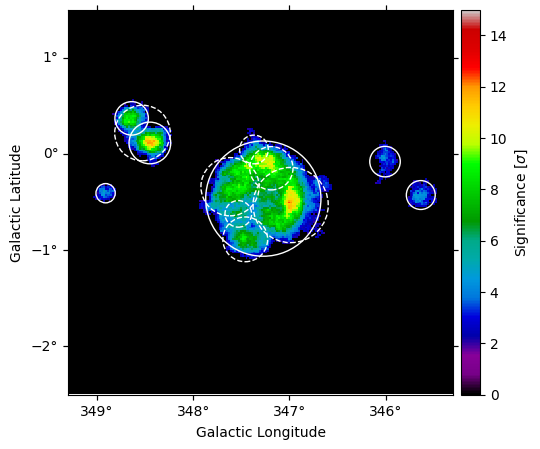

In [45]:
plt.figure(figsize=(7, 5))
ax = plt.subplot(111, projection=fig_geom.wcs)
plot_cutout(sig_rcorr0p1_fil, ax, resi_fil_kwargs)
candidate_models_main.plot_regions(ax=ax, color="w")
candidate_models_sub.plot_regions(ax=ax, color="w", ls="--")

## Fitting

Let's start the fitting as it will take some time.

In [46]:
models.freeze()
#unfreeze only the norm of the background models
for p in models.parameters:
    if p.name in ["norm"]:
        p.frozen = False
        p.min = 0

datasets.models = models + candidate_models_main

In [47]:
print("Number of free parameters", len(datasets.models.parameters.free_parameters))


Number of free parameters 47


In [48]:
from gammapy.datasets.actors import DatasetsActor

actors = DatasetsActor(datasets.copy())

Gammapy support for parallelisation with ray is still a prototype and is not fully functional.
2025-11-03 11:52:26,764	INFO worker.py:1942 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


In [49]:
start_time =time.time()

fit = Fit()

result = fit.run(datasets=actors)

print(result)

time_elapsed = time.time() - start_time
print("Fit time (min):", time_elapsed/60.)

(_MapDatasetActorBackend pid=17125) Position <SkyCoord (ICRS): (ra, dec) in deg
(_MapDatasetActorBackend pid=17125)     (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 9160
	total stat : 286815.08

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Fit time (min): 105.87430839935938


In [50]:
datasets.models = actors.models
datasets.models.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,norm,1.0375e+00,,2.686e-02,0.000e+00,nan,False,,
,norm,2.9903e+01,,1.985e+00,0.000e+00,nan,False,,
,amplitude,2.3422e-09,TeV-1 s-1 cm-2,9.119e-11,0.000e+00,nan,False,,
,alpha,1.8465e+00,,1.920e-02,0.000e+00,5.000e+00,False,,
,beta,6.2374e-02,,7.389e-03,0.000e+00,1.000e+00,False,,
,lon_0,3.4727e+02,deg,1.355e-02,3.467e+02,3.479e+02,False,,
,lat_0,-4.2186e-01,deg,1.426e-02,-1.080e+00,1.501e-01,False,,
,r_0,5.8181e-01,deg,1.121e-02,2.912e-01,1.230e+00,False,,
,eta,3.1962e-01,,3.823e-02,1.000e-01,1.000e+00,False,,


Let's check the residuals

In [63]:
%%time
results_combined_rcorr0p1_main_fit = get_combined_significance_maps(estimator_rcorr0p1, datasets)
ts_results_joint_main_fit = ts_estimator.run(datasets)

CPU times: user 1.72 s, sys: 622 ms, total: 2.35 s
Wall time: 2.23 s


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,


<WCSAxes: >

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


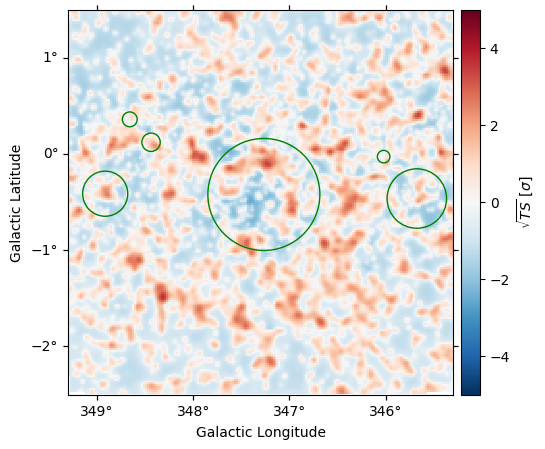

In [67]:

plt.figure(figsize=(7, 5))
ax = plt.subplot(111, projection=fig_geom.wcs)

resi_kwargs["clim"] = [-5, 5]
plot_cutout(ts_results_joint_main_fit["sqrt_ts"], ax, resi_kwargs)

Models([datasets.models[name] for name in candidate_models_main.names]).plot_regions(ax=ax, color="g")

Let's check if there is any significant excess left at the substructures positions:

In [79]:
peak_resi_sig = ts_results_joint_main_fit["sqrt_ts"].reduce_over_axes().get_by_coord(MapCoord.create(candidate_models_sub.positions))
order = np.argsort(peak_resi_sig)[::-1]
for name, significance in zip(np.array(candidate_models_sub.names)[order], peak_resi_sig[order]):
    print(name, significance)


Seed_2 2.4837713882846417
Seed_0 2.4249515010839287
Seed_7 1.9727329769188264
Seed_9 1.788542755733158
Seed_6 0.6642924864206017
Seed_11 0.4078342637412083
Seed_1 -0.8990134801945994


yes but not very significant, still we would try to more components one-by-one, starting with "Seed_2"...

First let's save the results

In [80]:
datasets.write(
    filename="./datasets/joint_datasets.yaml",
    filename_models="./models/models_joint_main_only.yaml", overwrite=True
)

Template file already exits, and overwrite is False


**In the next tutorial we will discuss, alternative hypothesis testing, and model selection** 